# Gender Classifiers
Given an audio file as input, classifiy the speaker as either male or female.

This notebook creates dataset generators, and builds, trains and evaluates Gender Classifier models.

It is meant to be run on the Paperspace platform, with access to GPUs for the training of the models.

In [33]:
# Set up the environment
#!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import soundfile as sf

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Sequential, load_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


In [34]:
# Set constants
SAMP_RATE = 16000
BATCH_SIZE=32
CLF='gender'

In [35]:
# Load the data
meta = pd.read_csv('processed.csv', index_col='speakerid')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


# Create data generators

## Load the VGGish model
The model needs to be instantiated before the dataset generator is called.

In [4]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

## Create lists of the files to feed the generator

In [5]:
train_names = os.listdir('storage/data/gender/train')
train_paths = ['storage/data/gender/train/{}'.format(i) for i in train_names]
print(train_paths[:5])
print(len(train_paths))

['storage/data/gender/train/english329.F.1o.wav', 'storage/data/gender/train/ngemba2.F.1n.wav', 'storage/data/gender/train/portuguese14.M.0o.wav', 'storage/data/gender/train/english27.F.0o.wav', 'storage/data/gender/train/ukrainian4.M.0n.wav']
5562


In [6]:
val_names = os.listdir('storage/data/gender/validation')
val_paths = ['storage/data/gender/validation/{}'.format(i) for i in val_names]
print(val_paths[:5])
print(len(val_paths))

['storage/data/gender/validation/french60.F.0n.wav', 'storage/data/gender/validation/bai1.F.0o.wav', 'storage/data/gender/validation/gedeo1.M.0n.wav', 'storage/data/gender/validation/lao2.F.2o.wav', 'storage/data/gender/validation/english416.M.0n.wav']
1852


In [7]:
test_names = os.listdir('storage/data/gender/test')
test_paths = ['storage/data/gender/test/{}'.format(i) for i in test_names]
print(test_paths[:5])
print(len(test_paths))

['storage/data/gender/test/macedonian21.F.0o.wav', 'storage/data/gender/test/english391.F.1o.wav', 'storage/data/gender/test/taiwanese6.F.2o.wav', 'storage/data/gender/test/english194.M.0o.wav', 'storage/data/gender/test/dutch4.M.1o.wav']
1206


## Get sample sizes and number of batches for each dataset

In [8]:
# Print sizes of data splits
print("Number of training samples: ", len(train_paths))
print("Number of validation samples: ", len(val_paths))
print("Number of testing samples: ", len(test_paths))

Number of training samples:  5562
Number of validation samples:  1852
Number of testing samples:  1206


In [9]:
# Calculate how many dataset batches to generate
train_steps = np.int(np.ceil(len(train_paths)/BATCH_SIZE)) -1
val_steps = np.int(np.ceil(len(val_paths)/BATCH_SIZE))-1
eval_steps = np.int(np.ceil(len(test_paths)/BATCH_SIZE))-1

print("training_steps_per_epoch = ", train_steps)
print("validation_steps = ", val_steps)
print("evaluation_steps = ", eval_steps)

training_steps_per_epoch =  173
validation_steps =  57
evaluation_steps =  37


## Define the generator and generate a dataset to check it works correctly

In [10]:
def tf_data_generator(file_list, batch_size=32):
    '''Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    vggish_model  - pass the instantiated model to the function
    batch_size - how many files to process at a time'''
    
    i = 1
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=1
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[(i-1)*batch_size:i*batch_size]
            data = []
            labels = []
            label_classes = tf.constant(['M', 'F'])
            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename
                bytes_string = file
                string_name = str(bytes_string, 'utf-8')
                split_str = string_name.split('.')
                #print(split_str)
                pattern = tf.constant(split_str[1])
                #print(pattern)
                for j in range(len(label_classes)):
                    if re.match(pattern.numpy(), label_classes[j].numpy()):
                        labels.append(j)

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [11]:
dataset_check = tf.data.Dataset.from_generator(tf_data_generator,
                                         args = [train_paths[:2*BATCH_SIZE], BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) )

In [12]:
# Check shape and size of dataset batches
for data, labels in dataset_check.take(2):
    print(data.shape)
    print(labels)

(32, 10, 128)
tf.Tensor(
[1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 1.], shape=(32,), dtype=float32)
(32, 10, 128)
tf.Tensor(
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 1.], shape=(32,), dtype=float32)


## Generate the datasets to feed the model.

In [13]:
train_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [train_paths, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 
validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [val_paths, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) )
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [test_paths, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 

# Build the model(s)

In [14]:
# Modified from https://console.paperspace.com/gcn-team/notebook/prcnk5wzd
# Set constants
DROPOUT = 0.5
DENSE_ACTIVATION = 'relu'
FINAL_ACTIVATION  = 'sigmoid'
LOSS = 'binary_crossentropy'

NUM_EPOCHS=100
EARLY_STOP_AFTER = 5

TRAIN_STEPS = train_steps
VAL_STEPS = val_steps
EVAL_STEPS = eval_steps

In [15]:
def create_gender_model(n_layers, n_nodes):
    model = Sequential()
    #Input shape (None, 10, 128)
    model.add(Input(shape=(10, 128), batch_size=BATCH_SIZE ))
    
    for i in range(n_layers):
        model.add(Dense(n_nodes/(i+1), activation=DENSE_ACTIVATION))
        model.add(Dropout(DROPOUT))

    model.add(Flatten())
    # Output
    model.add(Dense(1, activation=FINAL_ACTIVATION) )

    model.compile(loss=LOSS, optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
    return model

In [16]:
def plot_accuracy(model_name, hist_df, fig_path):
    plt.plot(hist_df['accuracy'])
    plt.plot(hist_df['val_accuracy'])
    plt.title('Accuracy: {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('{}.Accuracy.png'.format(fig_path))

def plot_loss(model_name, hist_df, fig_path):
    plt.plot(hist_df['loss'])
    plt.plot(hist_df['val_loss'])
    plt.title('Loss: {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('{}.Loss.png'.format(fig_path))

In [17]:
def evaluate_model(model, model_name, test_ds):
    # Evaluate the model
    #val_loss, val_acc, val_prec, val_recall = model.evaluate(val_ds, steps=VAL_STEPS)
    #test_loss, test_acc, test_prec, test_recall = model.evaluate(test_ds, steps=EVAL_STEPS)
    
    y_pred = model.predict(test_ds, steps=EVAL_STEPS)
    y_pred_int  = []
    for i in y_pred:
        if i < 0.5:
            y_pred_int.append(0)
        else: y_pred_int.append(1)
            
    # Get 1D array of labels from test_dataset
    y_lab = np.concatenate([y for x, y in test_ds.take(EVAL_STEPS)], axis=0)
    
    fig_path = ('storage/figures/gender/{}'.format(model_name))

    conf_mat = tf.math.confusion_matrix(y_lab, y_pred_int)
    print(conf_mat)
    sns.heatmap(conf_mat, annot = True, cmap='YlGnBu')
    plt.title("Confusion matrix: {}".format(model_name))
    plt.savefig('{}.ConfusionMatrix.png'.format(fig_path))

    return y_lab, y_pred_int

In [18]:
def run_model(n_layers, n_nodes, train_ds, val_ds, test_ds):
    
    # Create and compile the model
    model = create_gender_model(n_layers, n_nodes)
    
    model_name = 'Gender.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
    
    # Set up callbacks
    ckpt_name = '{}.ckpt'.format(model_name)
    ckpt_path = 'storage/models/gender/{}'.format(ckpt_name)
    ckpt_dir = os.path.dirname(ckpt_path)

    ckpt = ModelCheckpoint(filepath=ckpt_path,
                           monitor='val_loss',
                           save_weights_only=True,
                           mode='auto',
                           save_best_only=True)
    
    early_stopping = EarlyStopping(patience=EARLY_STOP_AFTER)
    
    # Train the model
    hist = model.fit(train_ds, steps_per_epoch = TRAIN_STEPS, epochs=NUM_EPOCHS, 
                     validation_data=val_ds, validation_steps=VAL_STEPS,
                    callbacks=[early_stopping, ckpt])
    
    # Plot training history and save figures
    hist_df = pd.DataFrame(hist.history)
    fig_path = ('storage/figures/gender/{}'.format(model_name))
    plot_accuracy(model_name, hist_df, fig_path)
    plot_loss(model_name, hist_df, fig_path)

    # Save the model
    model.save('storage/models/gender/{}'.format(model_name))
    hist_csv_file = 'storage/models/gender/{}.csv'.format(model_name)

    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Evaluate the model
    print(model.metrics_names)
    val_loss, val_acc, val_prec, val_recall = model.evaluate(val_ds, steps=VAL_STEPS)
    test_loss, test_acc, test_prec, test_recall = model.evaluate(test_ds, steps=EVAL_STEPS)
    
    y_lab, y_pred = evaluate_model(model, model_name, test_ds)
    
    print('{} complete'.format(model_name))
    
    return model, hist_df, y_lab, y_pred

## Model 1
This model will have one hidden layer with 128 nodes.

In [19]:
# Set model parameters
n_layers = 1
n_nodes = 128

model1_name = 'Gender.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model1_path = 'storage/models/gender/{}'.format(model1_name)
ckpt1_name = '{}.ckpt'.format(model1_name)
ckpt1_path = 'storage/models/gender/{}'.format(ckpt1_name)
ckpt1_dir = os.path.dirname(ckpt1_path)

In [20]:
print(model1_name)
print(model1_path)
print(ckpt1_path)
print(ckpt1_dir)

Gender.Dense.nLay1.nNodes128.dropout0.5
storage/models/gender/Gender.Dense.nLay1.nNodes128.dropout0.5
storage/models/gender/Gender.Dense.nLay1.nNodes128.dropout0.5.ckpt
storage/models/gender


In [22]:
if os.path.isdir(model1_path):
    model1 = tf.keras.models.load_model(model1_path)
    print("Saved model loaded")
    model1.summary()
elif os.path.isdir(ckpt1_path):
    model1 = create_gender_model(n_layers, n_nodes)
    model1.load_weights(ckpt1_path)
    print("Model weights loaded")
    model1.summary()
else:
    print("Create a new model")
    model1, hist1, y1_lab, y1_pred = run_model(n_layers, n_nodes, train_dataset, validation_dataset, test_dataset)

Model weights loaded
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 10, 128)             16512     
_________________________________________________________________
dropout (Dropout)            (32, 10, 128)             0         
_________________________________________________________________
flatten (Flatten)            (32, 1280)                0         
_________________________________________________________________
dense_1 (Dense)              (32, 1)                   1281      
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
173/173 [==============================] - 1882s 11s/step - loss: 0.0948 - accuracy: 0.9648 - precision: 0.9638 - recall: 0.9649 - val_loss: 0.0699 - val_accuracy: 0.9836 - val_precision: 0.9766 - val_recall: 0.9898
Epoch 2/100
173/173 [==============================] - 1649s 10s/step - loss: 0.0367 - accuracy: 0.9883 - precision: 0.9894 - recall: 0.9868 - val_loss: 0.0738 - val_accuracy: 0.9814 - val_precision: 0.9722 - val_recall: 0.9898
Epoch 3/100
173/173 [==============================] - 1636s 9s/step - loss: 0.0307 - accuracy: 0.9899 - precision: 0.9905 - recall: 0.9890 - val_loss: 0.0685 - val_accuracy: 0.9857 - val_precision: 0.9842 - val_recall: 0.9864
Epoch 4/100
173/173 [==============================] - 1631s 9s/step - loss: 0.0289 - accuracy: 0.9904 - precision: 0.9916 - recall: 0.9890 - val_loss: 0.0745 - val_accuracy: 0.9825 - val_precision: 0.9754 - val_recall: 0.9887
Epoch 5/100
173/173 [==============================] - 1676s 10s/step - loss: 0.0263 - acc

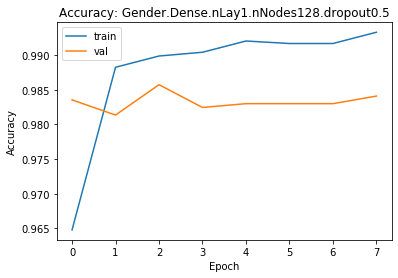

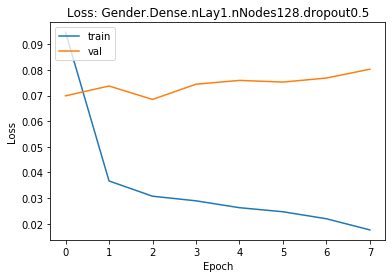

57/57 [==============================] - 396s 7s/step - loss: 0.0803 - accuracy: 0.9841 - precision: 0.9798 - recall: 0.9876


ValueError: too many values to unpack (expected 2)

<Figure size 432x288 with 0 Axes>

In [22]:
#model1, hist1 = run_model(n_layers=1, n_nodes=128, train_ds=train_dataset, val_ds=validation_dataset, test_ds=test_dataset)
#model1.summary()
# Original training history

## Comments
The model trained for 8 epochs, with the patience set to 5. This means the best val_loss value was in the 3rd epoch. Even with a 50% dropout layer, it seems difficult to avoid overfitting.

The validation data contains audio files that have been augmented with noise, as well as the original files.
The testing data only contains original audio files. Will there be a different in how well the model performs between these two datasets?

Something went wrong with the Evaluation part of the model - in the original code, which is now fixed. However, I am going to load the model from the last checkpoint and run the model evaluation manually.

In [29]:
model1.metrics_names
# Expect loss, accuracy, precision and recall

['loss', 'accuracy', 'precision', 'recall']

In [27]:
val_loss, val_acc, val_prec, val_recall = model1.evaluate(validation_dataset, steps=VAL_STEPS)

57/57 [==============================] - 456s 8s/step - loss: 0.0685 - accuracy: 0.9857 - precision: 0.9842 - recall: 0.9864


In [30]:
test_loss, test_acc, test_prec, test_recall = model1.evaluate(test_dataset, steps=EVAL_STEPS)

37/37 [==============================] - 299s 8s/step - loss: 0.0616 - accuracy: 0.9814 - precision: 0.9828 - recall: 0.9795


tf.Tensor(
[[590  10]
 [ 12 572]], shape=(2, 2), dtype=int32)


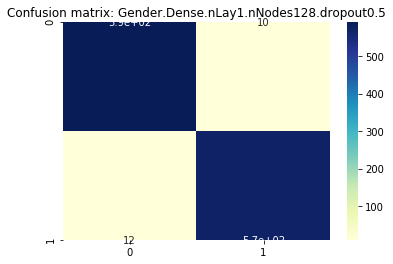

In [32]:
y1_lab, y1_pred = evaluate_model(model1, model1_name, test_dataset)

## Model 2
This model will have two hidden layers. The first has 128 nodes, the second has 64 nodes.

In [36]:
# Set model parameters
n_layers = 2

# First layer will have 128 nodes, second layer will have 128/2 = 64 nodes
n_nodes = 128

model2_name = 'Gender.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model2_path = 'storage/models/gender/{}'.format(model2_name)
ckpt2_name = '{}.ckpt'.format(model2_name)
ckpt2_path = 'storage/models/gender/{}'.format(ckpt2_name)
ckpt2_dir = os.path.dirname(ckpt2_path)

Create a new model
Epoch 1/100
173/173 [==============================] - 2088s 12s/step - loss: 0.1105 - accuracy: 0.9608 - precision: 0.9601 - recall: 0.9605 - val_loss: 0.0733 - val_accuracy: 0.9836 - val_precision: 0.9787 - val_recall: 0.9876
Epoch 2/100
173/173 [==============================] - 1885s 11s/step - loss: 0.0427 - accuracy: 0.9881 - precision: 0.9894 - recall: 0.9865 - val_loss: 0.0688 - val_accuracy: 0.9868 - val_precision: 0.9842 - val_recall: 0.9887
Epoch 3/100
173/173 [==============================] - 1846s 11s/step - loss: 0.0345 - accuracy: 0.9886 - precision: 0.9897 - recall: 0.9872 - val_loss: 0.0760 - val_accuracy: 0.9825 - val_precision: 0.9754 - val_recall: 0.9887
Epoch 4/100
173/173 [==============================] - 1811s 10s/step - loss: 0.0334 - accuracy: 0.9892 - precision: 0.9897 - recall: 0.9883 - val_loss: 0.0704 - val_accuracy: 0.9846 - val_precision: 0.9809 - val_recall: 0.9876
Epoch 5/100
173/173 [==============================] - 1836s 11s/step

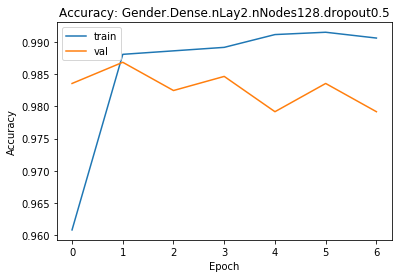

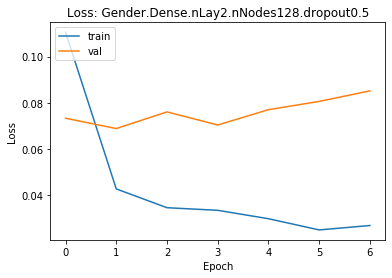

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: storage/models/gender/Gender.Dense.nLay2.nNodes128.dropout0.5/assets


INFO:tensorflow:Assets written to: storage/models/gender/Gender.Dense.nLay2.nNodes128.dropout0.5/assets


['loss', 'accuracy', 'precision', 'recall']
37/37 [==============================] - 253s 7s/step - loss: 0.0770 - accuracy: 0.9755 - precision: 0.9602 - recall: 0.9914
tf.Tensor(
[[576  24]
 [  5 579]], shape=(2, 2), dtype=int32)
Gender.Dense.nLay2.nNodes128.dropout0.5 complete


ValueError: too many values to unpack (expected 2)

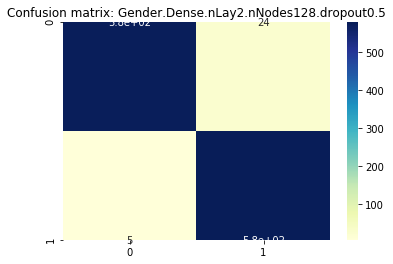

In [37]:
if os.path.isdir(model2_path):
    model2 = tf.keras.models.load_model(model2_path)
    print("Saved model loaded")
    model2.summary()
elif os.path.isdir(ckpt2_path):
    model2 = create_gender_model(n_layers, n_nodes)
    model2.load_weights(ckpt2_path)
    print("Model weights loaded")
    model2.summary()
else:
    print("Create a new model")
    model2, hist2 , y2_lab, y2_pred = run_model(n_layers, n_nodes, train_dataset, validation_dataset, test_dataset)

In [ ]:
y2_lab, y2_pred = evaluate_model(model2, model2_name, test_dataset)

In [ ]:
model2.summary()

# Comments

This model shows the steps in the training of both of the models. There were some errors in the original code to evaluate the models when the notebook was originally run. These errors have been fixed, but the code has not be rerun, to avoid losing the original training history.

The final evaluation of the models will be run in a separate notebook (4_ktr_GenderEval).